# 과제2 Code

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, f1_score


In [81]:
creditdata = pd.read_csv('./Data/creditcard.csv')

y = creditdata["Class"]
X = creditdata.loc[:, creditdata.columns != 'Class']
X = X.drop('Time', axis=1)

X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=123, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((227845, 29), (56962, 29), (227845,), (56962,))

In [82]:
print('사기 거래 갯수 : ', (y == 1).sum(), '\n', '정상 거래 갯수 : ', (y==0).sum(), '\n', '사기 비율 : ', (y == 1).sum() / len(y))

사기 거래 갯수 :  492 
 정상 거래 갯수 :  284315 
 사기 비율 :  0.001727485630620034


In [86]:
n_estimator = [50, 100, 150, 200, 250, 300]
learning_rate = [0.01, 0.02]
max_depth = [2, 4]
imbalance_y_ratio = [0.003, 0.004, 0.005, 0.01]

param_grid = dict(oss__sampling_strategy = imbalance_y_ratio,
                  gb__n_estimators = n_estimator,
                  gb__max_depth = max_depth,
                  gb__learning_rate = learning_rate)

kf = StratifiedKFold(n_splits=3)

GBmodel = Pipeline(
    [('oss', RandomUnderSampler()),
     ('fs', RFECV(LogisticRegression(), cv=5)),
     ('gb', GradientBoostingClassifier())]
)

grid = RandomizedSearchCV(estimator=GBmodel, param_distributions=param_grid, verbose=3, scoring='f1', cv=kf)

grid_result = grid.fit(X_train, y_train)

scores_df = pd.DataFrame(grid_result.cv_results_)
scores_df.head()

best_param = grid_result.best_params_
best_param

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END gb__learning_rate=0.01, gb__max_depth=2, gb__n_estimators=250, oss__sampling_strategy=0.003;, score=0.769 total time= 2.5min
[CV 2/3] END gb__learning_rate=0.01, gb__max_depth=2, gb__n_estimators=250, oss__sampling_strategy=0.003;, score=0.806 total time= 9.1min
[CV 3/3] END gb__learning_rate=0.01, gb__max_depth=2, gb__n_estimators=250, oss__sampling_strategy=0.003;, score=0.769 total time=154.9min
[CV 1/3] END gb__learning_rate=0.02, gb__max_depth=2, gb__n_estimators=250, oss__sampling_strategy=0.005;, score=0.853 total time=89.0min
[CV 2/3] END gb__learning_rate=0.02, gb__max_depth=2, gb__n_estimators=250, oss__sampling_strategy=0.005;, score=0.792 total time=24.6min
[CV 3/3] END gb__learning_rate=0.02, gb__max_depth=2, gb__n_estimators=250, oss__sampling_strategy=0.005;, score=0.777 total time=150.0min
[CV 1/3] END gb__learning_rate=0.02, gb__max_depth=2, gb__n_estimators=100, oss__sampling_strategy=0.005;, sc

f1 score = 0.7486033519553073


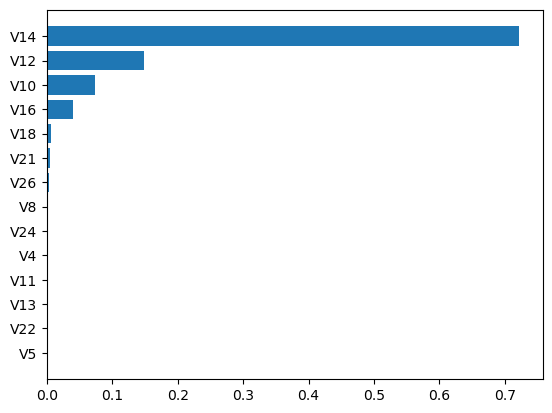

In [ ]:
RUS = RandomUnderSampler(sampling_strategy=best_param['oss__sampling_strategy'])

UX, Uy = RUS.fit_resample(X_train, y_train)

model = LogisticRegression()
rfecv = RFECV(model, cv=5)
rfecvfit = rfecv.fit(UX, Uy)

X_train_rfecvfit = UX[:, rfecvfit.get_support()]
X_test_rfecvfit = X_test[:, rfecvfit.get_support()]
y_train_rfecvfit = Uy
y_test_rfecvfit = y_test
  
gb_final = GradientBoostingClassifier(n_estimators = best_param['gb__n_estimators'],\
                                      max_depth = best_param['gb__max_depth'],\
                                      learning_rate = best_param['gb__learning_rate'])

gb_final.fit(X_train_rfecvfit, y_train_rfecvfit)

fimp = pd.Series(gb_final.feature_importances_, index=X.columns[rfecvfit.get_support()]).sort_values(ascending=True)
plt.barh(fimp.index, fimp.values)

y_pred3 = gb_final.predict(X_test_rfecvfit)
confusion_matrix(y_test, y_pred3)

print(f'f1 score = {f1_score(y_test, y_pred3)}')